# **AdamW [ Adam with Decoupled Weight Decay ]**

AdamW is just a crucial correction to how weight decay (a form of L2 regularization) is implemented in Adam.This small change has a significant impact on training large models **and** has become the standard for modern neural networks like Transformers.

---

In traditional setups, L2 regularization is implemented by adding a penalty term to the loss function. When the gradient is calculated, this results in a **"decay"** term being added to the gradient of the loss.

The problem is that in an adaptive optimizer like Adam, this entire gradient (including the deacay part) gets scaled by the adaptive denominator $(\sqrt{\hat{v_{t}}})$.This means that parameters with large historical gradients (a large $\hat{v_{t}}$) recieve a samller weight decay effect. This "tangles" the regularization with the gradient-based optimization, making the weight decay less effective and predictable than intended.

**AdamW Solution:**
**Decouple** the weight decay from the gradient update. The process works in two distinct steps:
1. **Adam Step:** The optimizer first performs the standard Adam update using only the gradients from the loss function. It calculates the momentum and adaptive scaling as usual to determine the step to take. 
2. **Decay Step:** After the Adam step is complete, the weights are decayed directly by subtracting a small fraction of their current value. The formula for this step is:
    $$w_{t+1} = w_{t} - \eta\lambda w_{t}$$
    where $\eta$ is the learning rate and $\lambda$  is the weight decay factor.

---

## **The Algorithm:**

The equations for AdamW are identical to Adam's for calculating the moving averages, but the final parameter update step is modified to decouple the weight decay.

Given the loss function L, the update rule for a weight **`w`** at timestep **`t`** is as follows:

1. Get the gradient of the loss function:
$$ g_{t} = \nabla L(w_{t}) $$
2. Update the first moment (moving average of gradients):
$$ m_{t} = \beta_{1} m_{t-1} + (1 - \beta_{1}) g_{t} $$
3. Update the second moment (moving average of squared gradients):
$$ v_{t} = \beta_{2} v_{t-1} + (1 - \beta_{2}) g_{t}^{2} $$
4. Compute bias-corrected moments:
$$ \hat{m_{t}} = \frac{m_{t}}{1-\beta_{1}^{t}}$$
$$ \hat{v_{t}} = \frac{v_{t}}{1-\beta_{2}^{t}}$$
5. Final parameter update with weight decay:
$$ w_{t+1} = w_{t} - \eta (\frac{\hat{m_{t}}}{\sqrt{\hat{v_{t}} + \epsilon}} + \lambda w_{t}) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

def linear_model(X, w, b): return X @ w.data + b.data
def mse_loss(y_true, y_pred): return np.mean((y_true - y_pred)**2)

def compute_gradients(X, y_true, y_pred, w, b):
    n_samples = len(y_true)
    grad_pred = -2 * (y_true - y_pred) / n_samples
    w.grad = X.T @ grad_pred
    b.grad = np.sum(grad_pred)

In [3]:
class Adam:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params; self.lr = lr; self.beta1 = beta1; self.beta2 = beta2; self.eps = eps
        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad**2)
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.data)

In [4]:
class AdamW:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        self.params = params; self.lr = lr; self.beta1 = beta1; self.beta2 = beta2; self.eps = eps
        self.weight_decay = weight_decay
        
        self.m = [np.zeros_like(p.data) for p in self.params] 
        self.v = [np.zeros_like(p.data) for p in self.params] 
        self.t = 0 # Timestep counter
    
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            # Standard Adam update logic
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad**2)
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            update_term = self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

            #Decoupled weight decay
            p.data -= update_term
            p.data -= self.lr * self.weight_decay * p.data
    
    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

Optimizer: Adam (lr=0.1)
Final Weights: w=2.01, b=1.20

Optimizer: AdamW (lr=0.1)
Final Weights: w=1.99, b=1.20



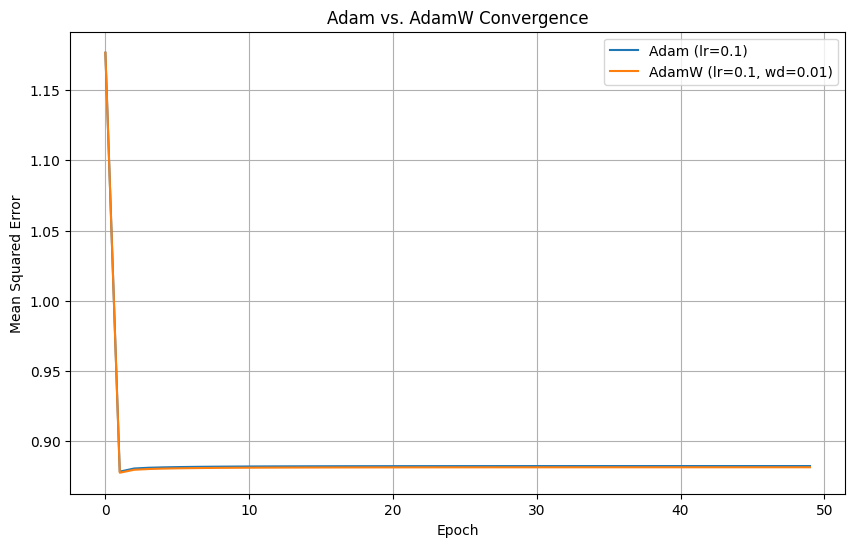

In [5]:
X = 2 * np.random.rand(100, 1)
y = 1 + 2 * X + np.random.randn(100, 1)

def train(optimizer, epochs=50):
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            x_sample, y_sample = X[i:i+1], y[i:i+1]
            w, b = optimizer.params
            y_pred = linear_model(x_sample, w, b)
            epoch_loss += mse_loss(y_sample, y_pred)
            optimizer.zero_grad()
            compute_gradients(x_sample, y_sample, y_pred, w, b)
            optimizer.step()
        loss_history.append(epoch_loss / len(X))
    
    current_lr = getattr(optimizer, 'lr', 'N/A')
    print(f"Optimizer: {optimizer.__class__.__name__} (lr={current_lr})")
    w, b = optimizer.params
    print(f"Final Weights: w={w.data.item():.2f}, b={b.data.item():.2f}\n")
    return loss_history

# with Adam
np.random.seed(42)
w_adam = Parameter(np.random.randn(1, 1)); b_adam = Parameter(np.zeros(1))
adam_optimizer = Adam(params=[w_adam, b_adam], lr=0.1)
adam_losses = train(adam_optimizer)

# with AdamW
np.random.seed(42)
w_adamw = Parameter(np.random.randn(1, 1)); b_adamw = Parameter(np.zeros(1))
adamw_optimizer = AdamW(params=[w_adamw, b_adamw], lr=0.1, weight_decay=0.01)
adamw_losses = train(adamw_optimizer)

plt.figure(figsize=(10, 6))
plt.plot(adam_losses, label='Adam (lr=0.1)')
plt.plot(adamw_losses, label='AdamW (lr=0.1, wd=0.01)')
plt.title('Adam vs. AdamW Convergence')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()